In [1]:
import os
import warnings

import joblib
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import (
    AutoConfig,
    AutoModel,
    AutoTokenizer,
    BertConfig,
    BertModel,
    BertTokenizerFast,
    PreTrainedModel,
)
from transformers.activations import ACT2FN

warnings.filterwarnings("ignore")

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

def global_ap(x):
    return torch.mean(x.view(x.size(0), x.size(1), -1), dim=1)

class SimSonEncoder(nn.Module):
    def __init__(self, config: BertConfig, max_len: int, dropout: float = 0.1):
        super(SimSonEncoder, self).__init__()
        self.config = config
        self.max_len = max_len
        
        self.bert = BertModel(config, add_pooling_layer=False)
        
        self.linear = nn.Linear(config.hidden_size, max_len)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input_ids, attention_mask=None):
        if attention_mask is None:
            attention_mask = input_ids.ne(0)
            
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        hidden_states = outputs.last_hidden_state
        
        hidden_states = self.dropout(hidden_states)
        
        pooled = global_ap(hidden_states)
        
        out = self.linear(pooled)
        
        return out

class SimSonClassifier(nn.Module):
    def __init__(self, encoder: SimSonEncoder, num_labels: int, dropout=0.1):
        super(SimSonClassifier, self).__init__()
        self.encoder = encoder
        self.clf = nn.Linear(encoder.max_len, num_labels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask=None, labels=None):
        x = self.encoder(input_ids, attention_mask)
        x = self.relu(self.dropout(x))
        x = self.clf(x)
        return x

In [10]:
import numpy as np
import torch
from torch.utils.data import Dataset


class SMILESDataset(Dataset):
    def __init__(self, smiles_list, labels, tokenizer, max_length=256):
        self.smiles_list = smiles_list
        self.labels = labels  # Shape: (num_samples, 2) - already scaled
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        # Create mask for valid (non-NaN) labels
        self.label_masks = ~np.isnan(self.labels)  # True where label is valid
        
        # Replace NaNs with 0 for safe tensor conversion (mask will handle exclusion)
        self.labels = np.nan_to_num(self.labels, nan=0.0)
    
    def __len__(self):
        return len(self.smiles_list)
    
    def __getitem__(self, idx):
        smiles = self.tokenizer.cls_token + self.smiles_list[idx]
        
        # Tokenize the SMILES string
        encoding = self.tokenizer(
            smiles,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float32),
            'label_mask': torch.tensor(self.label_masks[idx], dtype=torch.float32)
        }
    
    def get_label_statistics(self):
        """Return statistics about label availability"""
        label_counts = self.label_masks.sum(axis=0)
        total_samples = len(self.smiles_list)
        
        stats = {
            'total_samples': total_samples,
            'label_0_count': label_counts[0],
            'label_1_count': label_counts[1],
            'label_0_ratio': label_counts[0] / total_samples,
            'label_1_ratio': label_counts[1] / total_samples,
            'both_labels_count': (self.label_masks.sum(axis=1) == 2).sum(),
            'single_label_count': (self.label_masks.sum(axis=1) == 1).sum(),
            'no_labels_count': (self.label_masks.sum(axis=1) == 0).sum()
        }
        
        return stats

def calculate_weighted_loss(predictions, labels, label_mask, label_weights):
    """
    Calculate weighted loss for two labels with masking
    
    Args:
        predictions: Model outputs (batch_size, 2)
        labels: Ground truth labels (batch_size, 2)
        label_mask: Mask for valid labels (batch_size, 2)
        label_weights: Weights for each label (2,)
    """
    loss_fn = nn.MSELoss(reduction='none')
    
    # Calculate per-sample, per-label losses
    losses = loss_fn(predictions, labels)  # Shape: (batch_size, 2)
    
    # Apply masking to exclude NaN labels
    valid_mask = label_mask.bool()
    masked_losses = losses * valid_mask.float()
    
    # Apply label-specific weights
    weighted_losses = masked_losses * label_weights.unsqueeze(0)  # Broadcast weights
    
    # Calculate final loss (only over valid predictions)
    total_loss = weighted_losses.sum()
    total_valid = valid_mask.sum()
    
    return total_loss / total_valid if total_valid > 0 else torch.tensor(0.0, device=predictions.device, requires_grad=True)

def compute_label_weights(dataset):
    """
    Compute inverse frequency weights based on label availability
    
    Args:
        dataset: SMILESDataset instance
    
    Returns:
        torch.Tensor: Normalized weights for each label
    """
    # Get label counts from dataset
    label_counts = dataset.label_masks.sum(axis=0)  # Count valid samples per label
    total_samples = len(dataset)
    
    # Inverse frequency weighting
    weights = total_samples / (2 * label_counts)  # 2 is the number of labels
    
    # Normalize weights so they sum to number of labels (2)
    weights = weights / weights.sum() * 2
    
    return torch.tensor(weights, dtype=torch.float32)

def calculate_true_loss(predictions, labels, label_mask, scalers=None):
    """
    Calculate unscaled MAE loss for monitoring using separate scalers for each label
    
    Args:
        predictions (torch.Tensor): Model outputs of shape (batch_size, 2).
        labels (torch.Tensor): Ground truth labels of shape (batch_size, 2).
        label_mask (torch.Tensor): Boolean mask for valid labels of shape (batch_size, 2).
        scalers: List of scaler objects, one for each label
    """
    # Detach tensors from the computation graph and move to CPU
    predictions_np = predictions.cpu().detach().numpy()
    labels_np = labels.cpu().numpy()
    label_mask_np = label_mask.cpu().numpy().astype(bool)
    
    total_mae = 0
    total_samples = 0
    
    for label_idx in range(2):
        # Get valid samples for this label
        valid_mask = label_mask_np[:, label_idx]
        
        if valid_mask.any():
            valid_preds = predictions_np[valid_mask, label_idx].reshape(-1, 1)
            valid_labels = labels_np[valid_mask, label_idx].reshape(-1, 1)
            
            if scalers is not None:
                # Unscale using the corresponding scaler for this label
                unscaled_preds = scalers[label_idx].inverse_transform(valid_preds).flatten()
                unscaled_labels = scalers[label_idx].inverse_transform(valid_labels).flatten()
            else:
                unscaled_preds = valid_preds.flatten()
                unscaled_labels = valid_labels.flatten()
            
            # Calculate MAE for this label
            mae = np.mean(np.abs(unscaled_preds - unscaled_labels))
            total_mae += mae * len(unscaled_preds)
            total_samples += len(unscaled_preds)
    
    return total_mae / total_samples if total_samples > 0 else 0.0


def train_model(model, train_dataloader, val_dataloader, label_weights, 
                scalers=None, num_epochs=10, learning_rate=2e-5, device='cuda', 
                patience=3, validation_steps=500):
    """
    Train model with weighted loss for two labels with step-based validation
    
    Args:
        model: CustomModel instance (should output 2 labels)
        train_dataloader: Training data loader
        val_dataloader: Validation data loader  
        label_weights: Tensor with weights for each label
        scalers: List of scalers for unscaled loss monitoring
        num_epochs: Number of training epochs
        learning_rate: Learning rate
        device: Training device
        patience: Early stopping patience (in validation steps)
        validation_steps: Perform validation every N training steps
    """
    model.to(device)
    label_weights = label_weights.to(device)
    
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    total_steps = len(train_dataloader) * num_epochs
    scheduler = LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=total_steps)
    
    train_losses = []
    val_losses = []
    
    # Early stopping initialization
    best_val_loss = float('inf')
    steps_no_improve = 0
    best_model_state = None
    
    # Training tracking
    global_step = 0
    running_train_loss = 0
    running_true_train_loss = 0
    train_steps_count = 0
    
    print(f"Label weights: {label_weights.cpu().numpy()}")
    print(f"Validation will be performed every {validation_steps} steps")
    
    model.train()
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        
        train_progress = tqdm(train_dataloader, desc="Training", leave=False)
        
        for batch_idx, batch in enumerate(train_progress):
            with torch.autocast(dtype=torch.float16, device_type="cuda"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                label_mask = batch['label_mask'].to(device)
                
                optimizer.zero_grad()
                
                # Model forward pass
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                )
                
                # Calculate weighted loss
                loss = calculate_weighted_loss(outputs, labels, label_mask, label_weights)
                
                # Calculate true loss for monitoring
                true_loss = calculate_true_loss(outputs, labels, label_mask, scalers)
            
            # Accumulate losses for averaging
            running_train_loss += loss.item()
            running_true_train_loss += true_loss
            train_steps_count += 1
            
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            scheduler.step()
            
            global_step += 1
            
            train_progress.set_postfix({
                'step': global_step,
                'loss': f'{loss.item():.4f}',
                'true_loss': f'{true_loss:.4f}',
                'lr': f'{scheduler.get_last_lr()[0]:.2e}'
            })
            
            # Perform validation every validation_steps
            if global_step % validation_steps == 0:
                # Calculate average training losses since last validation
                avg_train_loss = running_train_loss / train_steps_count
                avg_true_train_loss = running_true_train_loss / train_steps_count
                
                train_losses.append(avg_train_loss)
                
                # Reset running averages
                running_train_loss = 0
                running_true_train_loss = 0
                train_steps_count = 0
                
                # Validation
                model.eval()
                total_val_loss = 0
                total_true_val_loss = 0
                val_batches = 0

                with torch.no_grad():
                    for val_batch in val_dataloader:
                        with torch.autocast(dtype=torch.float16, device_type="cuda"):
                            input_ids = val_batch['input_ids'].to(device)
                            attention_mask = val_batch['attention_mask'].to(device)
                            labels = val_batch['labels'].to(device)
                            label_mask = val_batch['label_mask'].to(device)
                            
                            outputs = model(
                                input_ids=input_ids,
                                attention_mask=attention_mask,
                            )
                            
                            val_loss = calculate_weighted_loss(outputs, labels, label_mask, label_weights)
                            val_true_loss = calculate_true_loss(outputs, labels, label_mask, scalers)

                        total_val_loss += val_loss.item()
                        total_true_val_loss += val_true_loss
                        val_batches += 1
                    
                avg_val_loss = total_val_loss / val_batches
                avg_val_true_loss = total_true_val_loss / val_batches
                val_losses.append(avg_val_loss)
                
                print(f"\nStep {global_step} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | True train loss: {avg_true_train_loss:.4f} | True val loss: {avg_val_true_loss:.4f}")
                
                # Early stopping check and best model saving
                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    steps_no_improve = 0
                    best_model_state = model.state_dict().copy()
                    print(f"New best validation loss: {best_val_loss:.4f}")
                else:
                    steps_no_improve += 1
                    if steps_no_improve >= patience:
                        print(f"Early stopping triggered after {global_step} steps ({steps_no_improve} validation steps without improvement).")
                        # Load best model and return
                        if best_model_state is not None:
                            model.load_state_dict(best_model_state)
                            print(f"Loaded best model with validation loss: {best_val_loss:.4f}")
                        return train_losses, val_losses, best_val_loss
                
                model.train()
    
    # Handle any remaining training loss that hasn't been validated
    if train_steps_count > 0:
        avg_train_loss = running_train_loss / train_steps_count
        train_losses.append(avg_train_loss)
    
    # Load the best model state before returning
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with validation loss: {best_val_loss:.4f}")
    
    return train_losses, val_losses, best_val_loss

def run_training(smiles_train, smiles_test, labels_train, labels_test, 
                model, tokenizer, scalers, num_epochs=5, learning_rate=1e-5, 
                batch_size=256, validation_steps=500):
    """
    Complete training pipeline for two labels with step-based validation
    
    Args:
        smiles_train, smiles_test: Lists of SMILES strings
        labels_train, labels_test: numpy arrays of shape (num_samples, 2) - ALREADY SCALED
        model: CustomModel instance (configured for 2 outputs)
        tokenizer: Tokenizer instance
        scalers: List of 2 scalers, one for each label (for inverse transform only)
        num_epochs: Number of training epochs
        learning_rate: Learning rate
        batch_size: Batch size for training
        validation_steps: Perform validation every N training steps
    """
    
    print("Setting up datasets for two-label training (labels assumed pre-scaled)")
    
    # Create datasets - no scaling performed here
    train_dataset = SMILESDataset(smiles_train, labels_train, tokenizer)
    val_dataset = SMILESDataset(smiles_test, labels_test, tokenizer)
    
    # Print dataset statistics
    train_stats = train_dataset.get_label_statistics()
    val_stats = val_dataset.get_label_statistics()
    
    print("Training dataset statistics:")
    for key, value in train_stats.items():
        print(f"  {key}: {value}")
    
    print("Validation dataset statistics:")
    for key, value in val_stats.items():
        print(f"  {key}: {value}")
    
    # Compute label weights based on training data
    label_weights = compute_label_weights(train_dataset)
    print(f"Computed label weights: {label_weights.numpy()}")
    
    # Create data loaders
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    
    val_dataloader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    print(f"Training steps per epoch: {len(train_dataloader)}")
    print(f"Total training steps: {len(train_dataloader) * num_epochs}")
    
    # Train the model
    train_losses, val_losses, best_val_loss = train_model(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        label_weights=label_weights,
        scalers=scalers,  # Still pass scalers for true loss calculation
        num_epochs=num_epochs,
        learning_rate=learning_rate,
        device=device,
        patience=10,
        validation_steps=validation_steps,
    )
    
    print('Training completed.')
    print(f'Number of validation checkpoints: {len(val_losses)}')
    print(f'Final training losses: {train_losses[-5:] if len(train_losses) >= 5 else train_losses}')
    print(f'Best validation loss: {best_val_loss:.4f}')
    
    # Save model
    torch.save(model.state_dict(), '/home/jovyan/simson_training_bolgov/regression/regression_simson.pth')
    print("Model saved successfully!")
    
    return train_losses, val_losses, best_val_loss

In [3]:
import pandas as pd

df = pd.read_csv('/home/jovyan/simson_training_bolgov/regression/PI_Tg_P308K_synth_db_chem.csv')
targets = ['Tg', 'He', 'N2', 'O2', 'CH4', 'CO2']

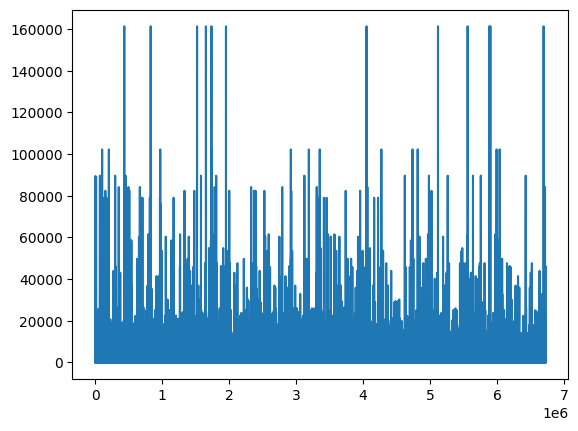

In [6]:
from matplotlib import pyplot as plt

plt.plot(df['CO2'].to_list())

In [4]:
tokenizer_path = 'DeepChem/ChemBERTa-77M-MTR'
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

# Only the hidden size is slightly larger, everything else is the same
config = BertConfig(
        vocab_size=tokenizer.vocab_size,
        hidden_size=768,
        num_hidden_layers=4,
        num_attention_heads=12,
        intermediate_size=2048,
        max_position_embeddings=512
    )

simson_params = torch.load('/home/jovyan/simson_training_bolgov/simson_checkpoints_1M/checkpoint_best_model.bin')

backbone = SimSonEncoder(config=config, max_len=512)
backbone = torch.compile(backbone)
backbone.load_state_dict(simson_params)


model = SimSonClassifier(encoder=backbone, num_labels=len(targets))
model = torch.compile(model, fullgraph=True)

In [5]:
def create_splits(df):
    length = len(df)
    train_length = int(0.99 * length)
    train = df.loc[:train_length]
    test = df.loc[train_length:]
    return train, test

train, test = create_splits(df)

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [6]:
scalers = []

for target in targets:
    target_scaler = StandardScaler()
    train[target] = target_scaler.fit_transform(train[target].to_numpy().reshape(-1, 1))
    test[target] = target_scaler.transform(test[target].to_numpy().reshape(-1, 1))
    
    scalers.append(target_scaler)

smiles_train = train['Smiles']
smiles_test = test['Smiles']

labels_train = train[targets].values
labels_test = test[targets].values

In [7]:
import joblib

joblib.dump(scalers, '/home/jovyan/simson_training_bolgov/regression/scalers')

['/home/jovyan/simson_training_bolgov/regression/scalers']

In [8]:
import numpy as np
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR
from torch.utils.data import DataLoader
from tqdm import tqdm

train_losses, val_losses, best_loss = run_training(
     smiles_train, smiles_test, labels_train, labels_test, 
     model, tokenizer, scalers, num_epochs=3, learning_rate=2e-5, batch_size=256, validation_steps=7000,
)

Setting up datasets for two-label training (labels assumed pre-scaled)
Training dataset statistics:
  total_samples: 6659681
  label_0_count: 6659681
  label_1_count: 6659681
  label_0_ratio: 1.0
  label_1_ratio: 1.0
  both_labels_count: 0
  single_label_count: 0
  no_labels_count: 0
Validation dataset statistics:
  total_samples: 67270
  label_0_count: 67270
  label_1_count: 67270
  label_0_ratio: 1.0
  label_1_ratio: 1.0
  both_labels_count: 0
  single_label_count: 0
  no_labels_count: 0
Computed label weights: [0.33333334 0.33333334 0.33333334 0.33333334 0.33333334 0.33333334]
Using device: cuda
Training steps per epoch: 26015
Total training steps: 78045
Label weights: [0.33333334 0.33333334 0.33333334 0.33333334 0.33333334 0.33333334]
Validation will be performed every 7000 steps

Epoch 1/3


Training:  27%|██▍      | 7001/26015 [10:27<10:43:20,  2.03s/it, step=7002, loss=0.0372, true_loss=16.0679, lr=1.84e-05]


Step 7000 | Train Loss: 0.0618 | Val Loss: 0.1191 | True train loss: 17.4244 | True val loss: 18.3473
New best validation loss: 0.1191


Training:  54%|████▎   | 14001/26015 [20:40<3:46:01,  1.13s/it, step=14002, loss=0.0315, true_loss=15.1059, lr=1.68e-05]


Step 14000 | Train Loss: 0.0357 | Val Loss: 0.0652 | True train loss: 16.0534 | True val loss: 17.3651
New best validation loss: 0.0652


Training:  81%|██████▍ | 21001/26015 [30:53<1:34:27,  1.13s/it, step=21002, loss=0.0348, true_loss=15.9539, lr=1.52e-05]


Step 21000 | Train Loss: 0.0319 | Val Loss: 0.0438 | True train loss: 15.7137 | True val loss: 16.3045
New best validation loss: 0.0438



Epoch 2/3


Training:   8%|▋        | 1987/26015 [02:59<5:37:18,  1.19it/s, step=28002, loss=0.0224, true_loss=14.3285, lr=1.35e-05]


Step 28000 | Train Loss: 0.0284 | Val Loss: 0.0393 | True train loss: 15.0774 | True val loss: 15.2044
New best validation loss: 0.0393


Training:  35%|███      | 8987/26015 [13:13<3:55:46,  1.20it/s, step=35002, loss=0.0302, true_loss=13.3737, lr=1.19e-05]


Step 35000 | Train Loss: 0.0257 | Val Loss: 0.0279 | True train loss: 14.4303 | True val loss: 14.4498
New best validation loss: 0.0279


Training:  61%|████▉   | 15987/26015 [23:29<2:17:59,  1.21it/s, step=42002, loss=0.0264, true_loss=14.5345, lr=1.03e-05]


Step 42000 | Train Loss: 0.0245 | Val Loss: 0.0351 | True train loss: 14.1197 | True val loss: 14.2312


Training:  88%|████████▊ | 22987/26015 [33:46<41:56,  1.20it/s, step=49002, loss=0.0216, true_loss=14.1316, lr=8.70e-06]


Step 49000 | Train Loss: 0.0233 | Val Loss: 0.0290 | True train loss: 13.9434 | True val loss: 14.4628



Epoch 3/3


Training:  15%|█▎       | 3971/26015 [05:52<7:13:46,  1.18s/it, step=56002, loss=0.0254, true_loss=14.4344, lr=7.08e-06]


Step 56000 | Train Loss: 0.0229 | Val Loss: 0.0479 | True train loss: 13.9115 | True val loss: 14.0929


Training:  42%|███▎    | 10971/26015 [16:06<4:48:34,  1.15s/it, step=63002, loss=0.0201, true_loss=12.8691, lr=5.47e-06]


Step 63000 | Train Loss: 0.0219 | Val Loss: 0.0239 | True train loss: 13.6746 | True val loss: 13.5177
New best validation loss: 0.0239


Training:  69%|██████▏  | 17971/26015 [26:24<2:31:18,  1.13s/it, step=7e+4, loss=0.0248, true_loss=14.9835, lr=3.86e-06]


Step 70000 | Train Loss: 0.0212 | Val Loss: 0.0259 | True train loss: 13.5072 | True val loss: 13.7410


Training:  96%|█████████▌| 24971/26015 [36:41<19:36,  1.13s/it, step=77002, loss=0.0228, true_loss=13.9553, lr=2.24e-06]


Step 77000 | Train Loss: 0.0207 | Val Loss: 0.0267 | True train loss: 13.4052 | True val loss: 13.8021


Loaded best model with validation loss: 0.0239
Training completed.
Number of validation checkpoints: 11
Final training losses: [0.022863016219410514, 0.02186289042873042, 0.021151691354678145, 0.020719855580878046, 0.020669196563010864]
Best validation loss: 0.0239
Model saved successfully!
